In [26]:
import numpy as np; 
def kfilter(y, num, x0, v0, A, C, Q, R):
    x_f = np.zeros(num); v_f = np.zeros(num);
    x_p = np.zeros(num); v_p = np.zeros(num);
    x_f[-1] = x0; v_f[-1] = v0;
    for i in range(num):
        x_p[i] = A*x_f[i-1]
        v_p[i] = A*v_f[i-1]*A + Q
        K = v_p[i]*C/(C*v_p[i]*C+R)
        x_f[i] = x_p[i] + K*(y[i]-C*x_p[i])
        v_f[i] = v_p[i] - K*C*v_p[i]
    return {'x_f':x_f,'v_f':v_f,'x_p':x_p,'v_p':v_p, 'K_T':K}
def ksmooth(y, num, x_f, v_f, x_p, v_p, A, vvT):
    x_s = np.zeros(num); v_s = np.zeros(num); J = np.zeros(num-1); P = np.zeros(num)
    x_s[num-1] = x_f[num-1]; v_s[num-1] = v_f[num-1]
    P[num-1] =  v_s[num-1] + x_s[num-1]*x_s[num-1]
    for i in range(1,num)[::-1]:
        J[i-1] = v_f[i-1]*A/v_p[i]
        x_s[i-1] = x_f[i-1] + J[i-1]*(x_s[i]-x_p[i])
        v_s[i-1] = v_f[i-1] + J[i-1]*(v_s[i]-v_p[i])*J[i-1]
        P[i-1] =  v_s[i-1] + x_s[i-1]*x_s[i-1]
    PP = np.zeros(num-1); vv = np.zeros(num-1)
    vv[num-2] = vvT; PP[num-2] = vv[num-2] + x_s[num-1]*x_s[num-2]
    for i in range(2,num)[::-1]:
        vv[i-2] = v_f[i-1]*J[i-2] + J[i-1]*(vv[i-1]-A*v_f[i-1])*J[i-2]
        PP[i-2] = vv[i-2] + x_s[i-1]*x_s[i-2]
    return {'x_s':x_s,'v_s':v_s,'J':J,'P':P,'PP':PP}

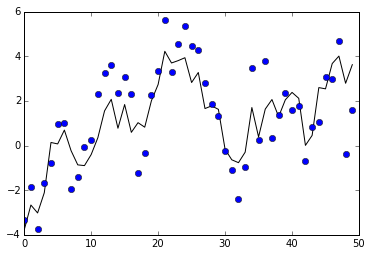

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
num = 50; x0 = 0; v0 = 1; A=1; C=1; Q=1; R=1;
w = np.random.normal(x0,Q,num+1); v = np.random.normal(0,R,num);
mu = np.cumsum(w);
y = mu[1:] + v;
t = np.arange(num)
plt.figure(1)
plt.plot(t,mu[1:],'k',t,y,'bo')
plt.show()

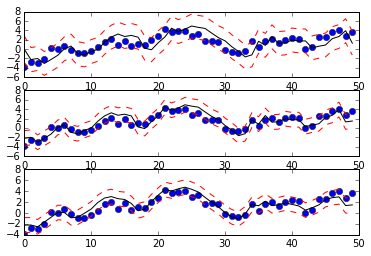

In [28]:
%matplotlib inline
ans1 = kfilter(y, num, x0, v0, A, C, Q, R)
x_f = ans1['x_f']; v_f = ans1['v_f']; x_p = ans1['x_p']; v_p = ans1['v_p']; K_T = ans1['K_T'];
ans2 = ksmooth(y, num, x_f, v_f, x_p, v_p, A, (1-K_T*C)*A*v_f[num-2]);

plt.figure(2)
plt.subplot(311)
plt.plot(t,mu[1:],'bo',t,ans1['x_p'],'k')
plt.plot(t,ans1['x_p']+2*np.sqrt(ans1['v_p']),'--r');
plt.plot(t,ans1['x_p']-2*np.sqrt(ans1['v_p']),'--r');
plt.subplot(312)
plt.plot(t,mu[1:],'bo',t,ans1['x_f'], 'k')
plt.plot(t,ans1['x_f']+2*np.sqrt(ans1['v_f']),'--r');
plt.plot(t,ans1['x_f']-2*np.sqrt(ans1['v_f']),'--r');
plt.subplot(313)
plt.plot(t,mu[1:],'bo',t,ans2['x_s'], 'k')
plt.plot(t,ans2['x_s']+2*np.sqrt(ans2['v_s']),'--r');
plt.plot(t,ans2['x_s']-2*np.sqrt(ans2['v_s']),'--r');

In [29]:
def klearn(y, num, x0, v0, A, C, Q, R):
    while True:
        flt = kfilter(y, num, x0, v0, A, C, Q, R)
        x_f = flt['x_f']; v_f = flt['v_f']
        x_p = flt['x_p']; v_p = flt['v_p']; K_T = flt['K_T']
        sm = ksmooth(y, num, x_f, v_f, x_p, v_p, A, (1-K_T*C)*A*v_f[num-2])
        x_s = sm['x_s']; P = sm['P']; PP = sm['PP']
        C = np.sum(y*x_s) / sum(P)
        Q = 1 # eps is normalized
        R = np.sum(y*y-C*x_s*y) / num
        A = np.sum(PP) / np.sum(P[:-1])
        x0 = x_s[0]
        v0 = P[0] - x_s[0]*x_s[0]
        yield x0, v0, A, C, Q, R

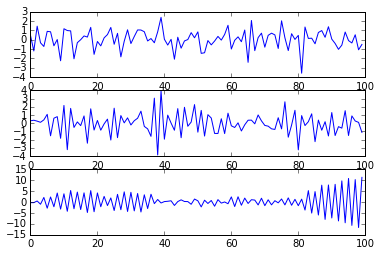

In [30]:
%matplotlib inline
from statsmodels.tsa.arima_process import arma_generate_sample, ArmaProcess
plt.figure(3)
series = [];
phiList = [-0.01,-0.7,-0.99]
np.random.seed(1234);
for i, phi in enumerate(phiList):
    arparams = np.array([1, -phi])
    maparams = np.array([1])
    arma_t = ArmaProcess(arparams, maparams)
    series.append(arma_t.generate_sample(nsample=100,scale=1))
    plt.subplot(311+i)
    plt.plot(series[i])
plt.show()

In [31]:
estIndexbyNoise = []
nList = np.arange(0.01,1.5,0.1)
initpars = np.array([0,1,1,1,1,1]) # initial values of x0, v0, A, C, Q, R
np.random.seed(1234);
for i, noise in enumerate(nList):
    est = []
    for j in range(3):
        learn = klearn(series[j]+np.random.normal(0,noise,100), 100, *initpars)
        for k in range(500):
            learn.next()
        _, _, phi, _, _, _ = learn.next()
        est.append(phi)
    estIndexbyNoise.append(est)
    if i%2 != 0:
        print 'noise={0}  phi1={1:6.3f}, phi2={2:6.3f}, phi3={3:6.3f} \n'.format(noise, *est)

noise=0.11  phi1=-0.328, phi2=-0.691, phi3=-1.011 

noise=0.31  phi1=-0.336, phi2=-0.654, phi3=-1.003 

noise=0.51  phi1=-0.477, phi2=-0.611, phi3=-1.005 

noise=0.71  phi1=-0.282, phi2=-0.599, phi3=-1.022 

noise=0.91  phi1=-0.200, phi2=-0.579, phi3=-1.018 

noise=1.11  phi1=-0.033, phi2=-0.525, phi3=-1.025 

noise=1.31  phi1=-0.366, phi2=-0.445, phi3=-1.011 



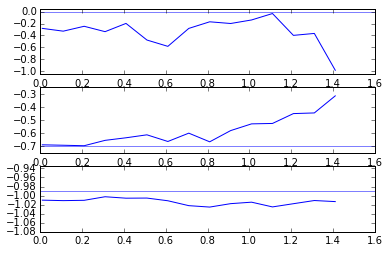

In [32]:
estIndexbySerie = zip(*estIndexbyNoise)
plt.figure(4)
for i in range(3):
    ax = plt.subplot(311+i)
    plt.plot(nList,np.array(estIndexbySerie[i]))
    ax.axhline(y=phiList[i],xmin=0,xmax=3,c="blue",linewidth=0.5,zorder=0)
    ymin = ax.get_ylim()[0]; ymax = ax.get_ylim()[1]
    ax.set_ylim(ymin-0.05,ymax+0.05)
    
plt.show()